In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

# Set seed
torch.manual_seed(123)
np.random.seed(123)
random.seed(123)

In [2]:
# Load the dataset
data = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

# Split data into features and labels
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DiabetesDataset(X_train, y_train)
test_dataset = DiabetesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(32 * X_train.shape[1], num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [4]:
input_channels = 1
num_classes = 2
model = CNN(input_channels, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

In [5]:
loss_list = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_list.append(running_loss/len(train_loader))
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [10/100], Loss: 0.5111
Epoch [20/100], Loss: 0.5086
Epoch [30/100], Loss: 0.5070
Epoch [40/100], Loss: 0.5057
Epoch [50/100], Loss: 0.5060
Epoch [60/100], Loss: 0.5052
Epoch [70/100], Loss: 0.5053
Epoch [80/100], Loss: 0.5049
Epoch [90/100], Loss: 0.5051
Epoch [100/100], Loss: 0.5047


In [6]:
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Calculate evaluation metrics
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print(f'F1 score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

F1 score: 0.7598
Precision: 0.7358
Recall: 0.7855
Accuracy: 0.7525


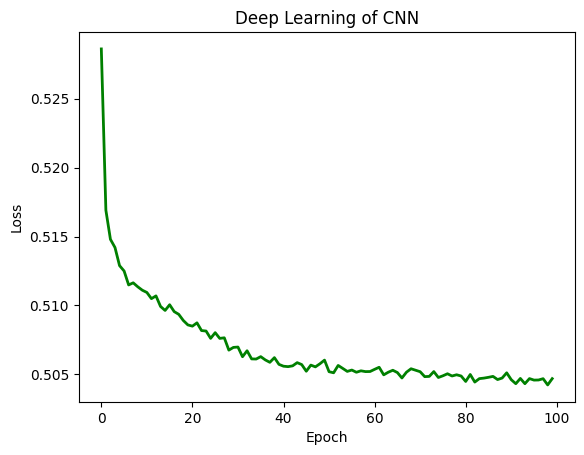

In [7]:
import matplotlib.pyplot as plt
plt.plot(loss_list, linewidth=2.0, color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Deep Learning of CNN')
plt.show()